In [874]:
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import base64
import inspect

from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_confusion_matrix
from xgboost import XGBClassifier
from dash.dependencies import Input, Output
from wordcloud import WordCloud
from PIL import Image
from os import path
from jupyter_plotly_dash import JupyterDash

In [881]:
inspect.getsourcelines(fun.clean)

(['def format_titles(title_list):\n',
  '    """This function formats the movie titles in such a way that they can be\n',
  '    discerned by the web site where the screenplays will be taken from.\n',
  '    \n',
  '    Parameter:\n',
  '    \n',
  '        title_list: list\n',
  '        list of titles to be formatted, generally from metacritic.\n',
  '        \n',
  '    Returns: \n',
  '    \n',
  '        list containing titles in the proper format for scraping screenplays from\n',
  '        springfieldspringfield.co.uk."""\n',
  '    \n',
  '    # Initializing list for later\n',
  '    titles_formatted = []\n',
  '    \n',
  '    # Will cycle through all titles and leave them in the correct format for\n',
  '    # later use.\n',
  '    for title in title_list:\n',
  '        title = title.lower()\n',
  '        \n',
  "        # Titles on this site have ', the' at the end.\n",
  "        if title[:3] == 'the':\n",
  "            title = title[4:] + ', the'\n",
  '        \n',
  "

In [2]:
import functions as fun

Using TensorFlow backend.


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
rotten_df_cut = pd.read_csv('rotten_df_cut.csv', index_col=0)
screenplays_cut = pd.read_csv('screenplays_cut.csv', index_col=0)

In [5]:
screenplays_cut.head()

,titles,scripts,good_or_bad,all_together_now,no_stop,just_words,word_count,unique_words,temp,sentiment_scores,sentiment_negative,sentiment_neutral,sentiment_positive,sentiment_compound,colon_ratios,semi_ratios,comma_ratios,ellipsis_ratios,sentence_length,category,Category Label,nlp,POS_counts,TAG_counts,PROPN,PUNCT,SYM,VERB,X,SPACE,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,UH,NNP,VBZ,MD,DT,IN,.,CC,VBN,NN,JJ,PRP,RB,VB,VBD,_SP,NNS,HYPH,``,XX,FW,WP,VBG,RBS,-LRB-,NFP,:,VBP,-RRB-,ADD,'',AFX,TO,",",EX,JJR,PRP$,POS,LS,WRB,RP,CD,NNPS,PDT,RBR,WDT,JJS,WP$,$
0,101-dalmatians,['\n\n [ Clock Chiming ...,1,\n\n [ Clock Chiming ] ...,[ clock chiming ] [ alarm ] [ groaning ] [ wh...,clock chiming alarm groaning whimpering barki...,8401,6219,<class 'str'>,"{'neg': 0.129, 'neu': 0.643, 'pos': 0.227, 'co...",0.129,0.643,0.227,0.9999,0.000482,0.000322,0.076379,0.015597,5.270339,2,Dark Movies and Documentaries,\n\n [ Clock Chiming ] ...,"{103: 63, 97: 3668, 96: 781, 100: 1512, 92: 12...","{6893682062797376370: 63, 17111077179131903759...",0.092965,0.436615,0.000000,0.179979,0.001666,0.007499,0.043923,0.044995,0.064040,0.005237,0.012499,0.069397,0.035234,0.150815,0.006904,0.018331,0.073920,0.035234,0.089751,0.022854,0.013927,0.053803,0.044995,0.127485,0.012499,0.013451,0.120105,0.041900,0.067492,0.056422,0.054279,0.013927,0.007499,0.030711,0.027259,0.000476,0.001666,0.0,0.006428,0.032853,0.000238,0.082014,0.005357,0.051065,0.033925,0.082014,0.0,0.003809,0.0,0.009404,0.057136,0.000714,0.001428,0.013094,0.002143,0.0,0.005833,0.006785,0.006904,0.003214,0.000833,0.000833,0.001666,0.000595,0.000000,0.000000
1,12-angry-men,['\n\n You did a wonder...,1,\n\n You did a wonderfu...,"wonderful job. wonderful. it. it! continue, y...",wonderful job wonderful continue youve listen...,13144,6953,<class 'str'>,"{'neg': 0.168, 'neu': 0.683, 'pos': 0.149, 'co...",0.168,0.683,0.149,-0.9997,0.002445,0.000000,0.083273,0.017259,3.542028,1,Action & Science Fiction,\n\n You did a wonderfu...,"{103: 2, 95: 2116, 100: 3407, 90: 1654, 84: 72...","{6893682062797376370: 2, 13656873538139661788:...",0.007912,0.247337,0.000456,0.259206,0.000000,0.000152,0.055463,0.079808,0.096318,0.008521,0.014836,0.125837,0.017194,0.154976,0.018868,0.030508,0.160986,0.017194,0.007912,0.038497,0.020161,0.106817,0.079808,0.147292,0.014836,0.017194,0.127739,0.053408,0.147139,0.082775,0.078591,0.044431,0.000152,0.027237,0.003271,0.001674,0.000000,0.0,0.013847,0.015140,0.000304,0.000000,0.002130,0.042605,0.053713,0.000000,0.0,0.006315,0.0,0.017651,0.044051,0.003043,0.001065,0.014912,0.002739,0.0,0.009814,0.010119,0.018868,0.000000,0.002206,0.000380,0.001826,0.000989,0.000076,0.000152
2,12-years-a-slave,"['\n\n All right now.',...",1,\n\n All right now. Y'a...,right now. y'all fresh niggers. y'all gonna c...,right yall fresh niggers yall gonna cutting g...,8092,4291,<class 'str'>,"{'neg': 0.163, 'neu': 0.632, 'pos': 0.204, 'co...",0.163,0.632,0.204,0.9992,0.000233,0.000000,0.127709,0.030529,3.116195,0,Classical & British,\n\n All right now. Y'a...,"{103: 2, 86: 618, 97: 2099, 84: 397, 92: 1255,...","{6893682062797376370: 2, 164681854541413346: 5...",0.079461,0.259392,0.000000,0.237024,0.000000,0.000247,0.049061,0.090213,0.076372,0.006179,0.023604,0.114310,0.017672,0.155091,0.008156,0.029906,0.144834,0.017672,0.078596,0.029412,0.022986,0.079338,0.090213,0.164113,0.023604,0.014459,0.126174,0.044983,0.136060,0.062531,0.088482,0.023480,0.000247,0.028917,0.002348,0.001483,0.000000,0.0,0.008774,0.011122,0.000741,0.000000,0.005067,0.014706,0.053262,0.000000,0.0,0.003955,0.0,0.014088,0.067721,0.002348,0.003089,0.031142,0.004696,0.0,0.009145,0.011122,0.008156,0.000865,0.001359,0.001607,0.002348,0.000989,0.000124,0.000000
3,127-hours,"['\n\n Hey. Aron here, ...",1,"\n\n Hey. Aron here, le...","hey. aron here, leave message. hi aron, sonja...",hey aron leave message hi aron sonja hereagai...,2191,1233,<class 'str'>,"{'neg': 0.15, 'neu': 0.586, 'pos': 0.264, 'com...",0.150,0.586,0.264,0.9996,0.004866,0.0

# Functions

In [6]:
def cut_down_dist(data1, data2, std_level, label_1, label_2):
    std = data1.mean() \
        + data1.std()*std_level
    
    plot_info_1 = data1.drop(data1[lambda x: x > std].index)
    
    std2 = data2.mean() \
        + data2.std()*std_level
    
    plot_info_2 = data2.drop(data2[lambda x: x > std].index)

    fig = plt.figure(figsize=(10,8))
    sns.distplot(plot_info_1, label=label_1, bins=100, norm_hist=False)
    sns.distplot(plot_info_2, label=label_2, bins=100, norm_hist=False)
    plt.legend()
    plt.show();

In [7]:
def top_words(words, max_features, min_df, max_df):
    """Takes in a series of documents and returns an ordered list of 
    how frequently words appear as calculated by sum vs count.
    
    Parameters:
    
        words: Series
            A series of documents with words to be counted.
            
        max_features: int
            Populates max_features value in vectorizer. Ceiling for how many
            words to use.
            
        min_df: float or int
            Populates min_df value in vectorizer. Minimum documents a word
            must appear in to be counted.
            
        max_df: float or int
            Populates max_df value in vectorizer. Maximum documents a word
            must appear in to be counted.
        
    returns: 
        List of tuples with word and ratio calculated by sum / count:
        (word, ratio), sorted by ratio."""
    
    # Initialize vectorizor and fit
    victor = CountVectorizer(max_features=max_features, 
                             min_df=min_df, max_df=max_df)
    movies_victor = victor.fit_transform(words)
    
    # Transform into SparceDataFrame.
    sdf = pd.SparseDataFrame(movies_victor, 
                                     columns=victor.get_feature_names())
    
    sdf.fillna(0, inplace=True)
    
    # Ave_word_count will house the tuples data to be sorted.
    ave_word_count = []
    for col in sdf.columns:
        key = col
        
        # Calculate the ratio and add tuple to list.
        value = sum(sdf[col]) / len(sdf[col])
        ave_word_count.append((key, value))
        
    # Return sorted tuple with word and ratio.
    return sorted(ave_word_count, key=lambda x: x[1], reverse=True)

# Visuals

In [8]:
sentence_length_0 = screenplays_cut[screenplays_cut.good_or_bad == 0]\
    ['sentence_length']
sentence_length_1 = screenplays_cut[screenplays_cut.good_or_bad == 1]\
    ['sentence_length']

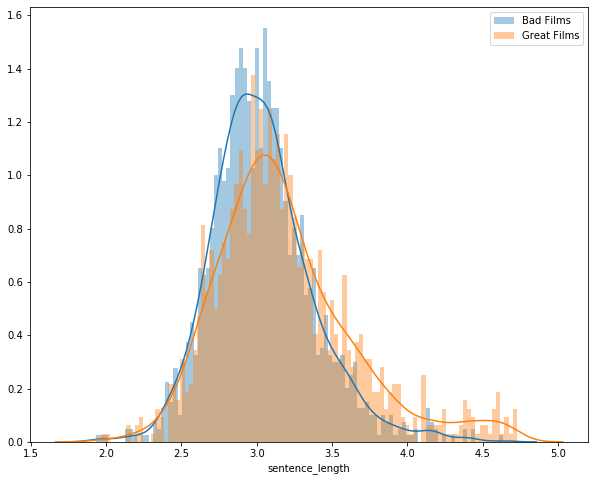

In [9]:
cut_down_dist(data1=sentence_length_0, data2=sentence_length_1, std_level=3,
              label_1='Bad Films', label_2='Great Films')

In [10]:
unique_words_0 = screenplays_cut[screenplays_cut.good_or_bad == 0]\
    ['unique_words']
unique_words_1 = screenplays_cut[screenplays_cut.good_or_bad == 1]\
    ['unique_words']

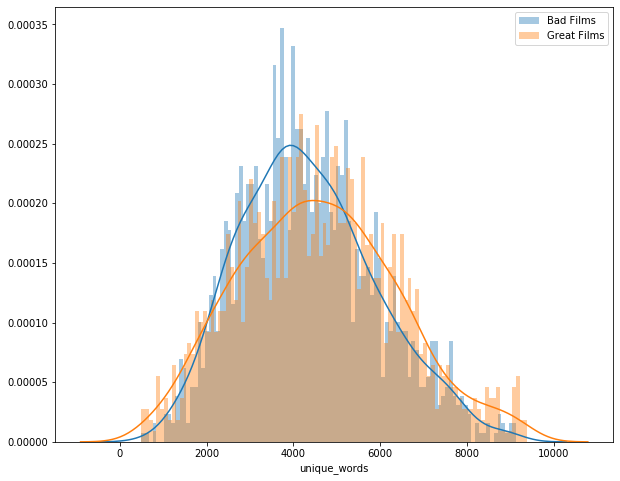

In [11]:
cut_down_dist(data1=unique_words_0, data2=unique_words_1, std_level=3,
              label_1='Bad Films', label_2='Great Films')

In [12]:
word_count_0 = screenplays_cut[screenplays_cut.good_or_bad == 0]\
    ['word_count']
word_count_1 = screenplays_cut[screenplays_cut.good_or_bad == 1]\
    ['word_count']

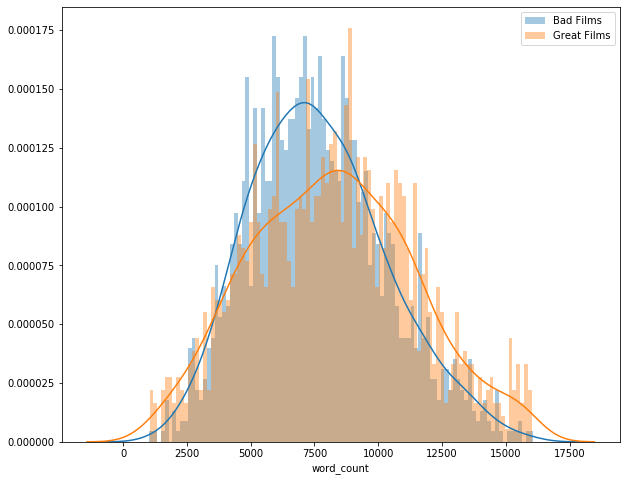

In [13]:
cut_down_dist(data1=word_count_0, data2=word_count_1, std_level=3,
              label_1='Bad Films', label_2='Great Films')

In [14]:
CC_0 = screenplays_cut[screenplays_cut.good_or_bad == 0]\
    ['CC']
CC_1 = screenplays_cut[screenplays_cut.good_or_bad == 1]\
    ['CC']

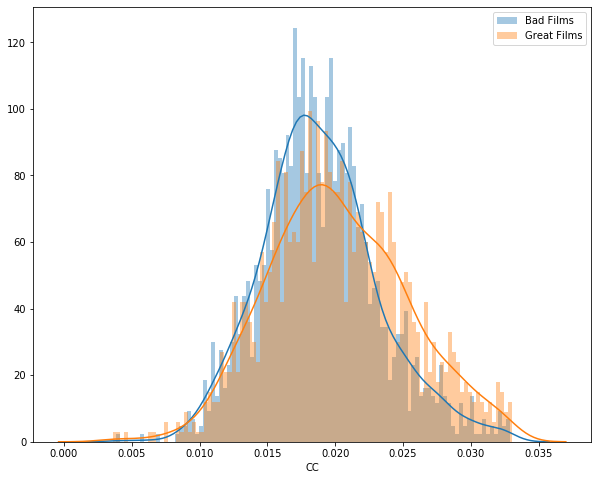

In [15]:
cut_down_dist(data1=CC_0, data2=CC_1, std_level=3,
              label_1='Bad Films', label_2='Great Films')

In [16]:
good_movies_nostop = screenplays_cut[
    screenplays_cut.good_or_bad == 1]['no_stop']

good_top_words = top_words(words=good_movies_nostop, max_features=5000, 
          min_df=.2, max_df=1.0)

In [17]:
bad_movies_nostop = screenplays_cut[
    screenplays_cut.good_or_bad == 0]['no_stop']

bad_top_words = top_words(words=bad_movies_nostop, max_features=5000, 
          min_df=.2, max_df=1.0)

In [18]:
# Creating list to separate words from tuples
just_bad_words = [wordpair[0] for wordpair in bad_top_words]

good_not_bad = [(wordpair[0], wordpair[1]) for wordpair in good_top_words
                if wordpair[0] not in just_bad_words]

good_not_bad

[('president', 1.222488038277512),
 ('film', 1.1754385964912282),
 ('la', 0.9792663476874003),
 ('general', 0.9577352472089314),
 ('18', 0.9043062200956937),
 ('government', 0.8875598086124402),
 ('16', 0.8046251993620415),
 ('17', 0.7910685805422647),
 ('500', 0.766347687400319),
 ('chief', 0.7639553429027113),
 ('bloody', 0.7304625199362041),
 ('ought', 0.7256778309409888),
 ('tea', 0.7192982456140351),
 ('24', 0.7169059011164274),
 ('united', 0.6507177033492823),
 ('river', 0.6467304625199362),
 ('states', 0.6347687400318979),
 ('200', 0.5629984051036683),
 ('stage', 0.5598086124401914),
 ('guilty', 0.5470494417862839),
 ('brown', 0.5358851674641149),
 ('papers', 0.507177033492823),
 ('pray', 0.4944178628389155),
 ('fellow', 0.48883572567783096),
 ('memory', 0.48325358851674644),
 ('teacher', 0.47527910685805425),
 ('streets', 0.47208931419457734),
 ('began', 0.4696969696969697),
 ('study', 0.46411483253588515),
 ('interest', 0.4625199362041467),
 ('orders', 0.46172248803827753),
 (

In [19]:
# Creating list to separate words from tuples
just_good_words = [wordpair[0] for wordpair in good_top_words]

bad_not_good = [(wordpair[0], wordpair[1]) for wordpair in bad_top_words
                if wordpair[0] not in just_good_words]

bad_not_good

[('dude', 1.5891318754141817),
 ('yo', 1.318754141815772),
 ('whoo', 1.023194168323393),
 ('ow', 1.0019880715705765),
 ('cop', 0.8031809145129225),
 ('agent', 0.7707090788601723),
 ('mommy', 0.7435387673956262),
 ('sweetie', 0.679920477137177),
 ('cell', 0.6779324055666004),
 ('outta', 0.6567263088137839),
 ('awesome', 0.6209410205434063),
 ('video', 0.6063618290258449),
 ('balls', 0.5891318754141815),
 ('killer', 0.5593108018555335),
 ('computer', 0.5447316103379721),
 ('flight', 0.5241882041086813),
 ('magic', 0.5182239893969516),
 ('babe', 0.5056328694499669),
 ('nuts', 0.49768058316766073),
 ('freak', 0.48442677269715045),
 ('code', 0.4711729622266402),
 ('super', 0.47051027170311466),
 ('aw', 0.4691848906560636),
 ('games', 0.464546056991385),
 ('drugs', 0.4625579854208085),
 ('beach', 0.46056991385023194),
 ('suck', 0.4546056991385023),
 ('ex', 0.45129224652087474),
 ('butt', 0.44002650762094103),
 ('bucks', 0.43803843605036447),
 ('weapon', 0.4234592445328032),
 ('gosh', 0.42147

In [20]:
good_string = ''

for wordpair in good_not_bad:
    mul = wordpair[1] * 20
    word_rep = (wordpair[0] + ' the ')*int(mul)
    good_string += word_rep

In [21]:
thumbs_down_mask = np.array(Image.open('images/thumbs-dwn-icon-black-th.svg.hi.png'))
thumbs_up_mask = np.array(Image.open('images/thumbs-up-icon-black-hi.png'))

## Word Clouds

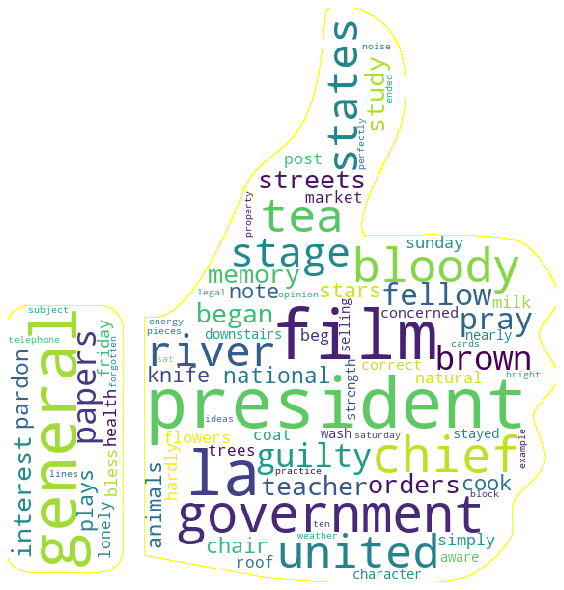

In [22]:
wordcloud = WordCloud(width=800, height=800, 
                      min_font_size=10,
                      background_color='white',
                      collocations=False,
                      mask=thumbs_up_mask,
                      contour_width=1,
                      contour_color='yellow').generate(good_string)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('images/good_cloud.png')
plt.show()

In [23]:
bad_string = ''

for wordpair in bad_not_good:
    mul = wordpair[1] * 20
    word_rep = (wordpair[0] + ' the ')*int(mul)
    bad_string += word_rep

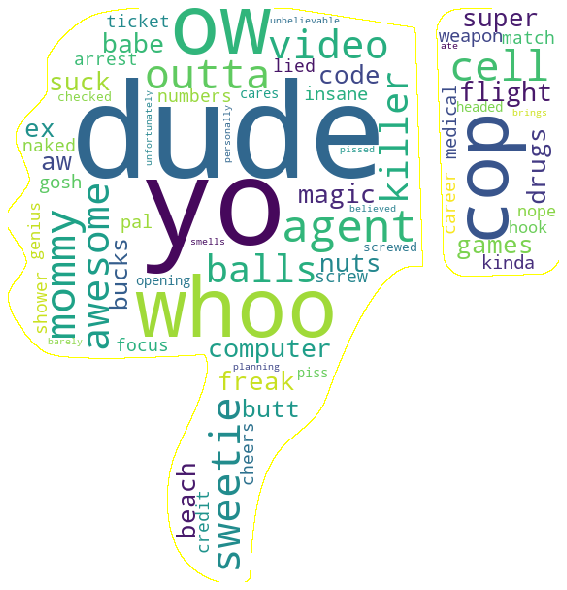

In [24]:
wordcloud = WordCloud(width=800, height=800, 
                      min_font_size=10,
                      background_color='white',
                      collocations=False,
                      mask=thumbs_down_mask,
                      contour_width=1,
                      contour_color='yellow').generate(bad_string)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('images/bad_cloud.png')
plt.show()

# Dashboard

## POS Histogram

In [838]:
screenplays_cut.columns

Index(['titles', 'scripts', 'good_or_bad', 'all_together_now', 'no_stop',
       'just_words', 'word_count', 'unique_words', 'temp', 'sentiment_scores',
       'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
       'sentiment_compound', 'colon_ratios', 'semi_ratios', 'comma_ratios',
       'ellipsis_ratios', 'sentence_length', 'category', 'Category Label',
       'nlp', 'POS_counts', 'TAG_counts', 'PROPN', 'PUNCT', 'SYM', 'VERB', 'X',
       'SPACE', 'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN',
       'NUM', 'PART', 'PRON', 'UH', 'NNP', 'VBZ', 'MD', 'DT', 'IN', '.', 'CC',
       'VBN', 'NN', 'JJ', 'PRP', 'RB', 'VB', 'VBD', '_SP', 'NNS', 'HYPH', '``',
       'XX', 'FW', 'WP', 'VBG', 'RBS', '-LRB-', 'NFP', ':', 'VBP', '-RRB-',
       'ADD', '''', 'AFX', 'TO', ',', 'EX', 'JJR', 'PRP$', 'POS', 'LS', 'WRB',
       'RP', 'CD', 'NNPS', 'PDT', 'RBR', 'WDT', 'JJS', 'WP$', '$'],
      dtype='object')

In [862]:
POS_abb = screenplays_cut.columns[list(screenplays_cut.columns).index(
    'word_count'):
                                  list(screenplays_cut.columns).index(
                                      'sentence_length')+1]
POS_abb = POS_abb.append(screenplays_cut.columns[list(screenplays_cut.columns).index(
    'PROPN'):
                                   list(screenplays_cut.columns).index(
                                       'PRON')+1])
POS_abb = list(POS_abb)
POS_abb.remove('temp')
POS_abb.remove('sentiment_scores')
POS_abb.remove('sentiment_compound')
POS_abb.remove('colon_ratios')
POS_abb.remove('semi_ratios')
POS_abb.remove('SYM')
POS_abb.remove('X')
POS_abb.remove('SPACE')

In [863]:
POS_abb

['word_count',
 'unique_words',
 'sentiment_negative',
 'sentiment_neutral',
 'sentiment_positive',
 'comma_ratios',
 'ellipsis_ratios',
 'sentence_length',
 'PROPN',
 'PUNCT',
 'VERB',
 'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON']

In [864]:
# List of dictionaries for script attribute dropdown
POS_desc = ['WORD COUNT', 'UNIQUE WORDS', 'NEGATIVE SENTIMENT', 
            'NEUTRAL SENTIMENT', 'POSITIVE SENTIMENT',
            'COMMAS', 'ELLIPSES', 'SENTENCE LENGTH',
            'PROPER NOUN', 'PUNCTUATION', 'SYMBOL', 'VERB', 'OTHER',
            'SPACE', 'ADJECTIVE', 'ADPOSITION', 'ADVERB', 
            'AUXILLIARY', 'COORDINATING CONJUNCTION', 'DETERMINER',
            'INTERJECTION', 'NOUN', 'NUMERICAL', 'PARTICIPLE',
            'PRONOUN']

In [865]:
POS_hist_dict = dict(zip(POS_abb, POS_desc))

POS_hist_selector_list = []

for k,v in POS_hist_dict.items():
    temp = dict()
    temp['label'] = v
    temp['value'] = k
    POS_hist_selector_list.append(temp)

In [866]:
POS_hist_selector_list

[{'label': 'WORD COUNT', 'value': 'word_count'},
 {'label': 'UNIQUE WORDS', 'value': 'unique_words'},
 {'label': 'NEGATIVE SENTIMENT', 'value': 'sentiment_negative'},
 {'label': 'NEUTRAL SENTIMENT', 'value': 'sentiment_neutral'},
 {'label': 'POSITIVE SENTIMENT', 'value': 'sentiment_positive'},
 {'label': 'COMMAS', 'value': 'comma_ratios'},
 {'label': 'ELLIPSES', 'value': 'ellipsis_ratios'},
 {'label': 'SENTENCE LENGTH', 'value': 'sentence_length'},
 {'label': 'PROPER NOUN', 'value': 'PROPN'},
 {'label': 'PUNCTUATION', 'value': 'PUNCT'},
 {'label': 'SYMBOL', 'value': 'VERB'},
 {'label': 'VERB', 'value': 'ADJ'},
 {'label': 'OTHER', 'value': 'ADP'},
 {'label': 'SPACE', 'value': 'ADV'},
 {'label': 'ADJECTIVE', 'value': 'AUX'},
 {'label': 'ADPOSITION', 'value': 'CCONJ'},
 {'label': 'ADVERB', 'value': 'DET'},
 {'label': 'AUXILLIARY', 'value': 'INTJ'},
 {'label': 'COORDINATING CONJUNCTION', 'value': 'NOUN'},
 {'label': 'DETERMINER', 'value': 'NUM'},
 {'label': 'INTERJECTION', 'value': 'PART'}

## Correlation Graph

Using XG Boost model to create feature importances.

hey              0.010333
help you         0.004770
somebody else    0.003859
destroy          0.003589
oh god           0.003469
go go            0.003389
trust me         0.003307
suppose          0.003283
he good          0.002882
out we           0.002862
it way           0.002807
group            0.002792
this you         0.002710
support          0.002581
okay good        0.002541
wondering        0.002522
said it          0.002497
coat             0.002370
got lot          0.002289
paul             0.002284
tickets          0.002241
it best          0.002218
best thing       0.002214
heart            0.002197
fuck it          0.002154
nonsense         0.002138
that want        0.002066
child            0.002056
horse            0.002053
wine             0.002024
here here        0.002000
leave it         0.001977
dollar           0.001970
sat              0.001965
fuck that        0.001947
me look          0.001943
sound            0.001939
expert           0.001908
ve gotta    

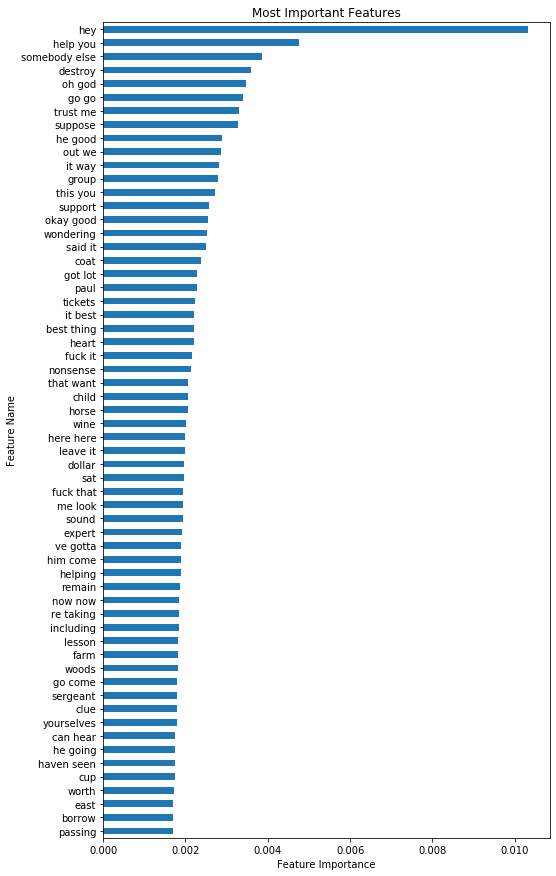

In [217]:
X_train = screenplays_cut.no_stop
y_train = screenplays_cut.good_or_bad

tfidf = TfidfVectorizer(max_df=.95, min_df=.1, max_features=5000,
                         ngram_range=(1,2))
X2 = tfidf.fit_transform(X_train)

# There a few more bad scripts than good ones, so I'll make them even.
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X2), y_train)

clf = XGBClassifier(max_depth=8,
                    criterion='entropy',
                    min_samples_split=14,
                    min_samples_leaf=1,
                    max_features=160)

clf.fit(X2, y_train)

columns = tfidf.get_feature_names()

print(pd.Series(clf.feature_importances_,
              index=columns).sort_values(ascending=False).head(60))
df_importance = pd.Series(clf.feature_importances_, 
                          index=columns)
df_importance = df_importance.sort_values(ascending=True).tail(60)
# df_importance.plot(kind='barh', figsize=(8,15))
# plt.title('Most Important Features')
# plt.ylabel('Feature Name')
# plt.xlabel('Feature Importance')
plt.show()

In [302]:
df_importance.sort_values(ascending=False, inplace=True)

In [303]:
important_df = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                               default_fill_value=0 )

In [304]:
important_df = important_df[list(df_importance.index)]
important_df['good_or_bad'] = y_train

In [305]:
important_corr = important_df.corr()

In [306]:
feature_corr = important_corr.good_or_bad.drop('good_or_bad', axis=0)
good_corr = important_corr[important_corr['good_or_bad'] > 0]['good_or_bad']
bad_corr = important_corr[important_corr['good_or_bad'] <= 0]['good_or_bad']
for i,v in bad_corr.items():
    value = v + abs(v*2)
    bad_corr.set_value(i,value) 
features_for_graph = pd.DataFrame([feature_corr, good_corr, bad_corr], 
                                  columns=['features', 'awesome', 'awful'])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [307]:
features_for_graph = {'features':df_importance, 'awesome':good_corr,
                          'awful':bad_corr}

In [308]:
features_for_graph = pd.DataFrame.from_dict(features_for_graph)\
    .drop('good_or_bad', axis=0)

In [403]:
features_for_graph

,features,awesome,awful
best thing,0.002214,0.001852,NaN
borrow,0.001695,NaN,0.011656
can hear,0.001757,NaN,0.029879
child,0.002056,0.025151,NaN
clue,0.001786,NaN,0.038595
coat,0.002370,0.078548,NaN
cup,0.001740,0.011371,NaN
destroy,0.003589,NaN,0.055310
dollar,0.001970,0.012086,NaN
east,0.001707,0.015452,NaN


In [310]:
good_corr = good_corr.drop('good_or_bad')
bad_corr = bad_corr.drop('good_or_bad')

In [497]:

data = go.Bar(x=bad_corr, y=bad_corr.index, orientation='h', 
              marker={'color':'rgba(250, 250, 0, .5)',
                                 'line':{'color':'rgba(0,0,0,1)',
                                         'width':1}})
layout = go.Layout(width=400, height=600, yaxis={'autorange':"reversed"})

fig = go.Figure(data, layout)

fig.show()

In [409]:
df_importance = df_importance[:25]
good_corr = good_corr[:25]
bad_corr = bad_corr[:25]

In [410]:
feature_selector_dicts = [{'label': 'Word Importance', 'value': 'df_importance'},
                          {'label': 'Awesome Film Words', 'value': 'good_corr'},
                          {'label': 'Awful Film Words', 'value': 'bad_corr'}]
# feature_selector_list = ['feature_corr', 'good_corr', 'bad_corr']
feature_selector_data = {'df_importance': df_importance, 'good_corr': good_corr,
                         'bad_corr': bad_corr}

In [498]:
feature_color_dicts = {'df_importance': 'rgba(250, 250, 0, .5)',
                       'good_corr': 'rgba(35,220,90,.75)',
                       'bad_corr': 'rgba(35,0,75,.5)'}
                       
                       
# colors={'rgba(255,20,20,1)', 'rgba(35,220,90,.75)'])

In [499]:
feature_color_dicts['df_importance']

'rgba(250, 250, 0, .5)'

## Unsupervised Category Predictions

In [508]:
combined_df = pd.read_csv('combined_df.csv', index_col=0)

In [674]:
cat_word_df = pd.read_csv('cat_word_df.csv', index_col=0)

In [510]:
lda_cats = [{'label':'Dark & Political', 'value':0,},
            {'label':'Sports, Comedy, Silly Horror', 'value':1},
            {'label':'Conflict', 'value':2},
            {'label':'Holiday, Films I Haven\'t Seen', 'value':3},
            {'label':'Light-Hearted', 'value':4},
            {'label':'Unusual Language or Slang', 'value':5},
            {'label':'Violence & Gangster', 'value':6},
            {'label':'Romance & Light Drama', 'value':7},
            {'label':'Life Stories', 'value':8},
            {'label':'Straight Up Horror', 'value':9}]

## Main Dash Code

In [867]:
# app = JupyterDash('POS_histogram')
app = dash.Dash()

# Reading in the files for the word cloud images.
image_filename = 'images/good_cloud.png'
encoded_good_cloud = base64.b64encode(
    open(image_filename, 'rb').read()).decode('ascii')

image_filename = 'images/bad_cloud.png'
encoded_bad_cloud = base64.b64encode(
    open(image_filename, 'rb').read()).decode('ascii')

# The main block of code generating the HTML. Using separate file for 
# CSS styling.
app.layout = html.Div(children=[
    html.H1(className='head',
            children=['What\'s a', html.Br(), 'Writer Worth?']
           ),
    html.H2(className='subHead',
            children=["""Screenplay Science and 
            the Value of a Few Good Words"""]
           ),
    html.Div(className='mainBox',
             children=[
        html.Div(className='subBox',
                 children=[
            
            # This is where the word clouds will go.
            html.Div(className='thumbBoxLeft',
                     children=[
                html.Img(className='thumbs',
                         src='data:image/png;base64,{}'.format(encoded_good_cloud)
                         ),
                html.Div(className='thumbDesc',
                          children=['The Good']),
                 ]),
            html.Div(className='thumbBoxRight',
                     children=[
                html.Div(className='thumbDesc',
                          children=['The Bad']),
                html.Img(className='thumbs',
                         src='data:image/png;base64,{}'.format(encoded_bad_cloud)
                        )
                 ]),
                     
            # This is where the histogram will go in from the callback.
            html.Div(id='hist', children=[
                dcc.Dropdown(id='hist_selector',
                         options=POS_hist_selector_list,
                         value='word_count'),
                dcc.Graph(
                    id='hist_graph',
                    figure=hist_figure)
                ]),
            dcc.RadioItems(
                id='feature_radio',
                options=feature_selector_dicts,
                value='df_importance'),
            dcc.Graph(
                id='feature_graph',
                figure=feature_figure),
                     
            # This is where we will show the LDA category information.
            html.Div(
                id='cat_div',
                children=[
                    dcc.Dropdown(id='cat_drop',
                                 options=lda_cats,
                                 value=0),
                    html.Div(id='cat_box'),
                    html.Div(id='cat_box_2')
                ])
            ]),
        ]),         
    ])

In [868]:
# Callback and function for POS graphs and switching dropdown.
@app.callback(Output(component_id='hist_graph', 
                     component_property='figure'),
              [Input(component_id='hist_selector',
                     component_property='value')])
def insert_hist(POS_label):
    
    data1 = screenplays_cut[screenplays_cut.good_or_bad == 1]\
    [POS_label]
    
    data0 = screenplays_cut[screenplays_cut.good_or_bad == 0]\
    [POS_label]
    
    std_high_1 = data1.mean() \
        + data1.std()*3
    std_low_1 = data1.mean() \
        - data1.std()*3
    
    plot_info_1 = data1.drop(data1[lambda x: x > std_high_1].index)
    plot_info_1 = plot_info_1.drop(plot_info_1[lambda x: x < std_low_1].index)
    
    std_high_0 = data0.mean() \
        + data0.std()*3
    std_low_0 = data0.mean() \
        - data0.std()*3
    
    plot_info_0 = data0.drop(data0[lambda x: x > std_high_0].index)
    plot_info_0 = plot_info_0.drop(plot_info_0[lambda x: x < std_low_0].index)
    
    bin_size=0
    
    if plot_info_1.mean() > 500:
        bin_size = 100
    elif plot_info_1.mean() > 1:
        bin_size = .1
    elif plot_info_1.mean() > .1:
        bin_size = .005
    elif plot_info_1.mean() > .01:
        bin_size = .001
    else:
        bin_size = .0004

#     return {'data':data, 'layout':layout}

#     return px.density_contour(plot_info_1)

    return ff.create_distplot([plot_info_1, plot_info_0], 
                              bin_size=bin_size,
                              group_labels=['Awesome Films', 'Awful Films'],
                              colors=['rgb(255,20,20)', 'rgb(35,230,90)'])

#     fig = px.histogram(x=plot_info_1, nbins=50)

In [869]:
#Callback and function for feature bar graph and radio buttons.
@app.callback(Output(component_id='feature_graph', 
                     component_property='figure'),
              [Input(component_id='feature_radio',
                     component_property='value')])
def insert_feature(radio_label):
    bar_data = [
        go.Bar(
            x=feature_selector_data[radio_label], 
            y=feature_selector_data[radio_label].index, 
            orientation='h', 
            marker={'color': feature_color_dicts[radio_label],
                     'line':{'color':'rgba(150,10,10,1)',
                             'width':1}})]

    bar_layout = go.Layout(width=400, height=700, yaxis={'autorange':"reversed"})

    return {'data':bar_data, 'layout':bar_layout}

In [870]:
# Callback and function for movies grouped by LDA categories.
@app.callback(Output(component_id='cat_box', 
                     component_property='children'),
              [Input(component_id='cat_drop',
                     component_property='value')])
def insert_titles(cat_id):
    
    movie_list = combined_df[combined_df.category == cat_id]['titles']
    
    formatted_titles = []
    
    for title in movie_list:
        temp = title.title().replace('-', ' ')
        if title[-4:] == '-the':
            temp = 'The ' + temp[:-4]
        
        formatted_titles.append(temp)
    
    for i in range(len(formatted_titles)):
        formatted_titles.insert(i*2, html.Br())
    
    # The below is to remove the initial line break that appears to to i*0
    formatted_titles.pop(0)
    
    return formatted_titles

In [871]:
# Callback for the LDA categories themselves.
@app.callback(Output(component_id='cat_box_2',
                     component_property='children'),
             [Input(component_id='cat_drop',
                    component_property='value')])
def insert_cats(cat_id):
    
    these_cats = list(cat_word_df[str(cat_id)])
    
    for i in range(len(these_cats)):
        these_cats.insert(i*2, html.Br())   

    these_cats.insert(0, html.Br())
    these_cats.insert(0, 'Most Significant Words')
    these_cats.insert(0, html.Br())
    
    return these_cats

In [872]:
if __name__ == '__main__':
    app.run_server(debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [13/Mar/2020 17:18:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2020 17:18:54] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2020 17:18:54] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2020 17:18:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2020 17:18:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2020 17:18:54] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2020 17:18:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2020 17:19:13] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2020 17:19:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2020 17:19:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2020 17:19:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [13/Mar/2020 17:19:27] "POST /_dash-update-component

In [826]:
# fig = px.histogram(screenplays_cut[['word_count','unique_words']], 
#                    x=['unique_words', 'unique_words'], y=['word_count', 
#                                                          'word_count'])
# fig.show()
# fig = ff.create_distplot([, group_labels, bin_size=.2)
# fig.show()

In [529]:
data1 = screenplays_cut[screenplays_cut.good_or_bad == 1]['NOUN']
data0 = screenplays_cut[screenplays_cut.good_or_bad == 0]['NOUN']
fig = ff.create_distplot([data1, data0], group_labels=['a','b'], bin_size=.004,
                        colors=['rgba(255,20,20,1)', 'rgba(35,220,90,.75)'])
fig.show()

In [50]:
screenplays_cut.head(1)

,titles,scripts,good_or_bad,all_together_now,no_stop,just_words,word_count,unique_words,temp,sentiment_scores,sentiment_negative,sentiment_neutral,sentiment_positive,sentiment_compound,colon_ratios,semi_ratios,comma_ratios,ellipsis_ratios,sentence_length,category,Category Label,nlp,POS_counts,TAG_counts,PROPN,PUNCT,SYM,VERB,X,SPACE,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,UH,NNP,VBZ,MD,DT,IN,.,CC,VBN,NN,JJ,PRP,RB,VB,VBD,_SP,NNS,HYPH,``,XX,FW,WP,VBG,RBS,-LRB-,NFP,:,VBP,-RRB-,ADD,'',AFX,TO,",",EX,JJR,PRP$,POS,LS,WRB,RP,CD,NNPS,PDT,RBR,WDT,JJS,WP$,$
0,101-dalmatians,['\n\n [ Clock Chiming ...,1,\n\n [ Clock Chiming ] ...,[ clock chiming ] [ alarm ] [ groaning ] [ wh...,clock chiming alarm groaning whimpering barki...,8401,6219,<class 'str'>,"{'neg': 0.129, 'neu': 0.643, 'pos': 0.227, 'co...",0.129,0.643,0.227,0.9999,0.000482,0.000322,0.076379,0.015597,5.270339,2,Dark Movies and Documentaries,\n\n [ Clock Chiming ] ...,"{103: 63, 97: 3668, 96: 781, 100: 1512, 92: 12...","{6893682062797376370: 63, 17111077179131903759...",0.092965,0.436615,0.0,0.179979,0.001666,0.007499,0.043923,0.044995,0.06404,0.005237,0.012499,0.069397,0.035234,0.150815,0.006904,0.018331,0.07392,0.035234,0.089751,0.022854,0.013927,0.053803,0.044995,0.127485,0.012499,0.013451,0.120105,0.0419,0.067492,0.056422,0.054279,0.013927,0.007499,0.030711,0.027259,0.000476,0.001666,0.0,0.006428,0.032853,0.000238,0.082014,0.005357,0.051065,0.033925,0.082014,0.0,0.003809,0.0,0.009404,0.057136,0.000714,0.001428,0.013094,0.002143,0.0,0.005833,0.006785,0.006904,0.003214,0.000833,0.000833,0.001666,0.000595,0.0,0.0


In [216]:
# screenplays_cut[screenplays_cut.sentence_length.apply(
#     lambda x: x > screenplays_cut.sentence_length.mean() 
#     + screenplays_cut.sentence_length.std()) == True]

In [61]:
POS_columns = screenplays_cut.columns[
    list(screenplays_cut.columns).index('PROPN'):
    list(screenplays_cut.columns).index('PRON')+1]

In [93]:
all_good = screenplays_cut[screenplays_cut.good_or_bad == 1]
all_bad = screenplays_cut[screenplays_cut.good_or_bad == 0]

good_POS_sent_ratios = []
bad_POS_sent_ratios = []

for col in POS_columns:
    
    good_POS_sent_ratios.append((col, round(all_good[col].mean() \
        / all_good.sentence_length.mean(),4)))
                                 
    bad_POS_sent_ratios.append((col, round(all_bad[col].mean() \
        / all_bad.sentence_length.mean(),4)))
    
good_POS_sent_ratios = sorted(good_POS_sent_ratios, key=lambda x: x[1], 
                              reverse=True)

bad_POS_sent_ratios = sorted(bad_POS_sent_ratios, key=lambda x: x[1], 
                              reverse=True)

In [96]:
POS_columns = screenplays_cut.columns[
    list(screenplays_cut.columns).index('UH'):
    list(screenplays_cut.columns).index('$')+1]

In [97]:
all_good = screenplays_cut[screenplays_cut.good_or_bad == 1]
all_bad = screenplays_cut[screenplays_cut.good_or_bad == 0]

good_POS_sent_ratios = []
bad_POS_sent_ratios = []

for col in POS_columns:
    
    good_POS_sent_ratios.append((col, round(all_good[col].mean() \
        / all_good.sentence_length.mean(),4)))
                                 
    bad_POS_sent_ratios.append((col, round(all_bad[col].mean() \
        / all_bad.sentence_length.mean(),4)))
    
good_POS_sent_ratios = sorted(good_POS_sent_ratios, key=lambda x: x[1], 
                              reverse=True)

bad_POS_sent_ratios = sorted(bad_POS_sent_ratios, key=lambda x: x[1], 
                              reverse=True)

In [101]:
print(good_POS_sent_ratios[:17])
print(bad_POS_sent_ratios[:17])

[('.', 0.0476), ('PRP', 0.0427), ('NN', 0.0347), ('DT', 0.0239), ('VB', 0.0239), ('RB', 0.0237), ('IN', 0.0226), (',', 0.0178), ('VBP', 0.0158), ('NNP', 0.0156), ('JJ', 0.0145), ('VBZ', 0.0104), ('VBD', 0.0096), (':', 0.0088), ('UH', 0.0081), ('NNS', 0.0081), ('CC', 0.0065)]
[('.', 0.0568), ('PRP', 0.0478), ('NN', 0.0378), ('VB', 0.0272), ('RB', 0.0256), ('DT', 0.0254), ('IN', 0.0228), (',', 0.0202), ('VBP', 0.0184), ('NNP', 0.0181), ('JJ', 0.0155), ('VBZ', 0.0117), ('UH', 0.0109), (':', 0.0101), ('VBD', 0.0097), ('NNS', 0.0083), ('VBG', 0.0066)]


In [129]:
good_movies_together = screenplays_cut[
    screenplays_cut.good_or_bad == 1]['all_together_now']

good_top_words = top_words(words=good_movies_together, max_features=5000,
                           min_df=0.1, max_df=1.0)

In [130]:
bad_movies_together = screenplays_cut[
    screenplays_cut.good_or_bad == 0]['all_together_now']

bad_top_words = top_words(words=bad_movies_together, max_features=5000,
                          min_df=0.1, max_df=1.0)

In [133]:
# Creating list to separate words from tuples
just_bad_words = [wordpair[0] for wordpair in bad_top_words]

good_not_bad = [(wordpair[0], wordpair[1]) for wordpair in good_top_words
                if wordpair[0] not in just_bad_words]

good_not_bad

[('lt', 1.6148325358851674),
 ('harry', 0.8740031897926634),
 ('mum', 0.7783094098883573),
 ('johnny', 0.7511961722488039),
 ('jim', 0.6961722488038278),
 ('21', 0.6889952153110048),
 ('19', 0.6754385964912281),
 ('23', 0.6347687400318979),
 ('26', 0.6012759170653907),
 ('sergeant', 0.562200956937799),
 ('richard', 0.5566188197767146),
 ('henry', 0.5526315789473685),
 ('charles', 0.511164274322169),
 ('german', 0.49282296650717705),
 ('vote', 0.474481658692185),
 ('ill', 0.4728867623604466),
 ('piano', 0.4585326953748006),
 ('soldiers', 0.45454545454545453),
 ('al', 0.45374800637958534),
 ('march', 0.44417862838915473),
 ('lieutenant', 0.42424242424242425),
 ('robert', 0.4043062200956938),
 ('union', 0.4043062200956938),
 ('madam', 0.4003189792663477),
 ('england', 0.39872408293460926),
 ('political', 0.37719298245614036),
 ('trial', 0.3668261562998405),
 ('british', 0.3628389154704944),
 ('americans', 0.36044657097288674),
 ('songs', 0.35645933014354064),
 ('400', 0.3397129186602871),

In [134]:
# Creating list to separate words from tuples
just_good_words = [wordpair[0] for wordpair in good_top_words]

bad_not_good = [(wordpair[0], wordpair[1]) for wordpair in bad_top_words
                if wordpair[0] not in just_good_words]

bad_not_good

[('ben', 1.0291583830351225),
 ('aah', 0.9310801855533466),
 ('gasps', 0.7249834327369119),
 ('grunts', 0.6123260437375746),
 ('grunting', 0.5931080185553347),
 ('groans', 0.5851557322730285),
 ('coach', 0.5632869449966865),
 ('screams', 0.5268389662027833),
 ('bro', 0.5162359178263751),
 ('ms', 0.4923790589794566),
 ('ohh', 0.46520874751491054),
 ('papa', 0.4367130550033135),
 ('hoo', 0.4254473161033797),
 ('groaning', 0.4068919814446653),
 ('grandpa', 0.39430086149768057),
 ('ugh', 0.39165009940357853),
 ('santa', 0.3697813121272366),
 ('doc', 0.341948310139165),
 ('ls', 0.3320079522862823),
 ('pee', 0.31809145129224653),
 ('gasping', 0.31544068919814444),
 ('boo', 0.30483764082173626),
 ('ahh', 0.294234592445328),
 ('sucks', 0.28561961563949634),
 ('tires', 0.28561961563949634),
 ('lab', 0.27899271040424123),
 ('pizza', 0.2783300198807157),
 ('sobbing', 0.26507620941020543),
 ('clears', 0.2637508283631544),
 ('chick', 0.26043737574552683),
 ('dating', 0.2591119946984758),
 ('cock', 

Using XG Boost model to create feature importances.

hey              0.010333
help you         0.004770
somebody else    0.003859
destroy          0.003589
oh god           0.003469
go go            0.003389
trust me         0.003307
suppose          0.003283
he good          0.002882
out we           0.002862
it way           0.002807
group            0.002792
this you         0.002710
support          0.002581
okay good        0.002541
wondering        0.002522
said it          0.002497
coat             0.002370
got lot          0.002289
paul             0.002284
tickets          0.002241
it best          0.002218
best thing       0.002214
heart            0.002197
fuck it          0.002154
nonsense         0.002138
that want        0.002066
child            0.002056
horse            0.002053
wine             0.002024
here here        0.002000
leave it         0.001977
dollar           0.001970
sat              0.001965
fuck that        0.001947
me look          0.001943
sound            0.001939
expert           0.001908
ve gotta    

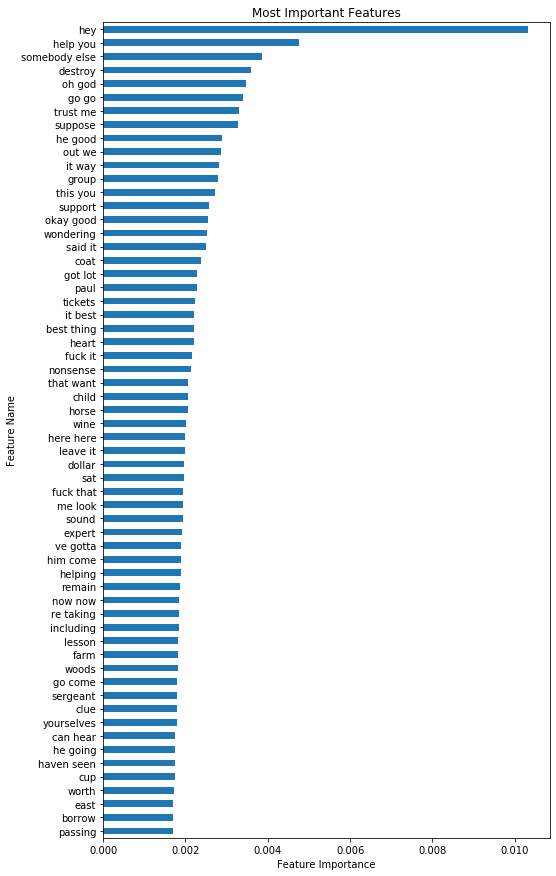

In [217]:
X_train = screenplays_cut.no_stop
y_train = screenplays_cut.good_or_bad

tfidf = TfidfVectorizer(max_df=.95, min_df=.1, max_features=5000,
                         ngram_range=(1,2))
X2 = tfidf.fit_transform(X_train)

# There a few more bad scripts than good ones, so I'll make them even.
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.DataFrame(X2), y_train)

clf = XGBClassifier(max_depth=8,
                    criterion='entropy',
                    min_samples_split=14,
                    min_samples_leaf=1,
                    max_features=160)

clf.fit(X2, y_train)

columns = tfidf.get_feature_names()

print(pd.Series(clf.feature_importances_,
              index=columns).sort_values(ascending=False).head(60))
df_importance = pd.Series(clf.feature_importances_, 
                          index=columns)
df_importance = df_importance.sort_values(ascending=True).tail(60)
# df_importance.plot(kind='barh', figsize=(8,15))
# plt.title('Most Important Features')
# plt.ylabel('Feature Name')
# plt.xlabel('Feature Importance')
plt.show()

In [302]:
df_importance.sort_values(ascending=False, inplace=True)

In [303]:
important_df = pd.SparseDataFrame(X2, columns=tfidf.get_feature_names(),
                               default_fill_value=0 )

In [304]:
important_df = important_df[list(df_importance.index)]
important_df['good_or_bad'] = y_train

In [305]:
important_corr = important_df.corr()

In [306]:
feature_corr = important_corr.good_or_bad.drop('good_or_bad', axis=0)
good_corr = important_corr[important_corr['good_or_bad'] > 0]['good_or_bad']
bad_corr = important_corr[important_corr['good_or_bad'] <= 0]['good_or_bad']
for i,v in bad_corr.items():
    value = v + abs(v*2)
    bad_corr.set_value(i,value) 
features_for_graph = pd.DataFrame([feature_corr, good_corr, bad_corr], 
                                  columns=['features', 'awesome', 'awful'])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



In [307]:
features_for_graph = {'features':df_importance, 'awesome':good_corr,
                          'awful':bad_corr}

In [308]:
features_for_graph = pd.DataFrame.from_dict(features_for_graph)\
    .drop('good_or_bad', axis=0)

## Correlation Graph

In [310]:
good_corr = good_corr.drop('good_or_bad')

In [342]:

data = go.Bar(x=bad_corr, y=bad_corr.index, orientation='h', 
              marker={'color':'rgba(255, 20, 20, .5)',
                                 'line':{'color':'rgba(150,10,10,1)',
                                         'width':1}})
layout = go.Layout(width=400, height=600, yaxis={'autorange':"reversed"})

fig = go.Figure(data, layout)

fig.show()